In [1]:
from sklearn.pipeline import make_pipeline
import numpy as np
from dense_subgraph import sdp, qp
import utils
import nested_cv
from cs_classification import cs_p1_graphs_to_points, cs_p2_graphs_to_points
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import classification_report

In [17]:
# Read brain graph files into numpy arrays
graphs_A = utils.get_graphs_from_files("../generated_datasets/pearson_corr_raw/datasets/children/asd/")
graphs_B = utils.get_graphs_from_files("../generated_datasets/pearson_corr_raw/datasets/children/td/")

graphs, labels = utils.label_and_concatenate_graphs(graphs_A, graphs_B, a_label="ASD", b_label="TD")

In [15]:
filtered_graphs=[]
filtered_labels=[]
for i in range(labels.shape[0]):
    if not np.isnan(np.sum(graphs[i])):
        filtered_graphs.append(graphs[i])
        filtered_labels.append(labels[i])
graphs = np.array(filtered_graphs)
labels = np.array(filtered_labels)

In [18]:
graphs.shape

(145, 116, 116)

In [3]:
class ContrastSubgraphTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, a_label=None, b_label=None,
                    alpha=None, alpha2=None,
                    percentile=None, percentile2=None,
                    problem=None, solver=None, num_cs=None) -> None:
        self.a_label = a_label
        self.b_label = b_label

        self.alpha = alpha
        self.alpha2 = alpha2 or alpha
        self.percentile = percentile
        self.percentile2 = percentile2 or percentile
        
        self.problem = problem
        self.solver = solver
        self.num_cs = num_cs

        self.cs_a_b_list = []
        self.cs_b_a_list = []
        self.cs_list = []

        self.alpha_provided = bool(self.alpha)

    def fit(self, X, y=None):
         # Create and Write Summary Graphs
        self.summary_A = utils.summary_graph(X[np.where(y == self.a_label)])
        self.summary_B = utils.summary_graph(X[np.where(y == self.b_label)])

        if self.problem == 1:
            self.find_cs_p1()
        else: # problem == 2
            self.find_cs_p2()
        
        return self

    def find_cs_p1(self) -> None:
        diff_a_b = self.summary_A - self.summary_B
        diff_b_a = self.summary_B - self.summary_A

        nodes = np.arange(diff_a_b.shape[0])
        node_mask_a_b = np.array([True]*nodes.shape[0])
        node_mask_b_a = np.array([True]*nodes.shape[0])

        for i in range(self.num_cs):
            masked_diff_a_b = utils.induce_subgraph(diff_a_b, nodes[node_mask_a_b])
            masked_diff_b_a = utils.induce_subgraph(diff_b_a, nodes[node_mask_b_a])

            # If no alpha value is provided, find the appropriate alpha value using the given percentile
            if not self.alpha_provided:
                # A -> B
                flat = masked_diff_a_b[np.triu_indices_from(masked_diff_a_b, k=1)]
                self.alpha = np.percentile(flat, self.percentile)
                print("alpha = {} ({}-th percentile)".format(self.alpha, self.percentile), end=", ")

                # B -> A
                flat = masked_diff_b_a[np.triu_indices_from(masked_diff_b_a, k=1)]
                self.alpha2 = np.percentile(flat, self.percentile2)
                print("alpha2 = {} ({}-th percentile)".format(self.alpha2, self.percentile2))

            cs_a_b = nodes[node_mask_a_b][self.solver(masked_diff_a_b, self.alpha)]
            self.cs_a_b_list.append(cs_a_b)
            cs_b_a = nodes[node_mask_b_a][self.solver(masked_diff_b_a, self.alpha2)]
            self.cs_b_a_list.append(cs_b_a)
            # Do not consider the previously found contrast subgraph nodes for future contrast subgraphs
            node_mask_a_b[cs_a_b] = False
            node_mask_b_a[cs_b_a] = False

            if len(nodes[node_mask_a_b]) == 0:
                print("Every node in the graph is included by a contrast subgraph(A->B)!\n\
                    Stopped at Contrast Subgraph {}.".format(i+1))
                break
            if len(nodes[node_mask_b_a]) == 0:
                print("Every node in the graph is included by a contrast subgraph (B->A)!\n\
                    Stopped at Contrast Subgraph {}.".format(i+1))
                break

    def find_cs_p2(self) -> None:
        diff = abs(self.summary_A - self.summary_B)

        nodes = np.arange(diff.shape[0])
        node_mask = np.array([True]*nodes.shape[0])
        
        for i in range(self.num_cs):
            masked_diff = utils.induce_subgraph(diff, nodes[node_mask])

            # If no alpha value is provided, find the appropriate alpha value using the given percentile
            if not self.alpha_provided:
                flat = masked_diff[np.triu_indices_from(masked_diff, k=1)]
                self.alpha = np.percentile(flat, self.percentile)
                print("alpha = {} ({}-th percentile)".format(self.alpha, self.percentile))
            
            cs = nodes[node_mask][self.solver(masked_diff, self.alpha)]
            self.cs_list.append(cs)
            node_mask[cs] = False

            if len(nodes[node_mask]) == 0:
                print("Every node in the graph is included by a contrast subgraph!\n\
                    Stopped at Contrast Subgraph {}.".format(i+1))
                break

    def transform(self, X):
        points = np.zeros((X.shape[0], 2))

        if self.problem == 1:
            num_cs = min(len(self.cs_a_b_list), len(self.cs_b_a_list))
            for i in range(num_cs):
                points += cs_p1_graphs_to_points(graphs=X,
                                                cs_a_b=self.cs_a_b_list[i],
                                                cs_b_a=self.cs_b_a_list[i])
        else: # problem == 2
            for i in range(len(self.cs_list)):
                points += cs_p2_graphs_to_points(graphs=X,
                                                contrast_subgraph=self.cs_list[i],
                                                summary_A=self.summary_A,
                                                summary_B=self.summary_B)
        return points

In [4]:
class DiscriminativeEdgesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, a_label: str, b_label: str, num_edges: int) -> None:
        self.a_label = a_label
        self.b_label = b_label

        self.num_edges = num_edges

        self.axes_labels = [f"% similarity between important {a_label} edges",
                            f"% similarity between important {b_label} edges",
                            f"% similarity of whole graph with {a_label} class"]

    def fit(self, graphs, labels) -> None:
        # Create and Write Summary Graphs
        summary_A = utils.summary_graph(graphs[np.where(labels == self.a_label)])
        summary_B = utils.summary_graph(graphs[np.where(labels == self.b_label)])
            
        # Get the difference network between the edge weights in group A and B
        # Note that (u,v) is the same as (v,u), so we extract the upper triangle of the matrix
        self.diff_net = np.triu(summary_A - summary_B, k=1)

        # Find the num_edges most positive and most negative edge diffs
        partitions = np.argpartition(self.diff_net, (self.num_edges, -self.num_edges), axis=None)
        top_n = np.unravel_index(partitions[-self.num_edges:], self.diff_net.shape)
        bottom_n = np.unravel_index(partitions[:self.num_edges], self.diff_net.shape)

        # Ensure the top edges are all positive and the bottom edges are all negative
        top_edges = self.diff_net[top_n]
        positive = top_edges > 0
        self.positive_indices = (top_n[0][positive], top_n[1][positive])
        self.important_a_edges = self.diff_net[self.positive_indices]

        bottom_edges = self.diff_net[bottom_n]
        negative = bottom_edges < 0
        self.negative_indices = (bottom_n[0][negative], bottom_n[1][negative])
        self.important_b_edges = self.diff_net[self.negative_indices]

        self.a_sum = np.sum(self.important_a_edges)
        self.b_sum = np.sum(self.important_b_edges)
        self.full_sum = np.sum(np.abs(self.diff_net))

        return self

    
    def transform(self, graphs):
        points = np.array(list(map(self.graph_to_point, graphs)))
        return points

    def graph_to_point(self, graph):
        graph[np.where(graph==0)] = -1
        return np.array([100*np.dot(self.important_a_edges, graph[self.positive_indices])/self.a_sum,
                         100*np.dot(self.important_b_edges, graph[self.negative_indices])/self.b_sum,
                         100*np.sum(np.multiply(graph, self.diff_net))/self.full_sum])

[{'results': {'report': {'ASD': {'precision': 0.75,
     'recall': 0.6,
     'f1-score': 0.6666666666666665,
     'support': 15},
    'TD': {'precision': 0.6470588235294118,
     'recall': 0.7857142857142857,
     'f1-score': 0.7096774193548386,
     'support': 14},
    'accuracy': 0.6896551724137931,
    'macro avg': {'precision': 0.6985294117647058,
     'recall': 0.6928571428571428,
     'f1-score': 0.6881720430107525,
     'support': 29},
    'weighted avg': {'precision': 0.7003042596348884,
     'recall': 0.6896551724137931,
     'f1-score': 0.6874304783092323,
     'support': 29}},
   'confusion_matrix': array([[ 9,  6],
          [ 3, 11]])},
  'params': {'DiscriminativeEdgesTransformer': {'a_label': 'ASD',
    'b_label': 'TD',
    'num_edges': 2},
   'SVC': {'C': 50, 'gamma': 1}},
  'trained_pipeline': [DiscriminativeEdgesTransformer(a_label='ASD', b_label='TD', num_edges=2),
   StandardScaler(),
   SVC(C=50, gamma=1)]},
 {'results': {'report': {'ASD': {'precision': 0.588235294

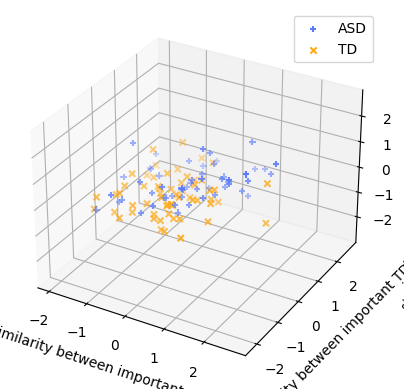

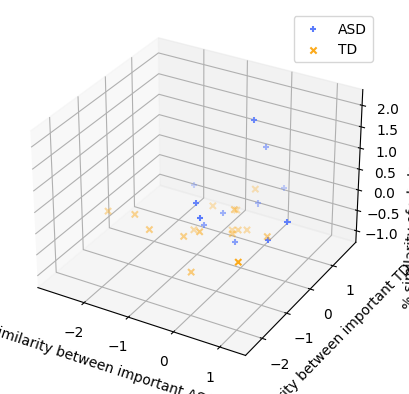

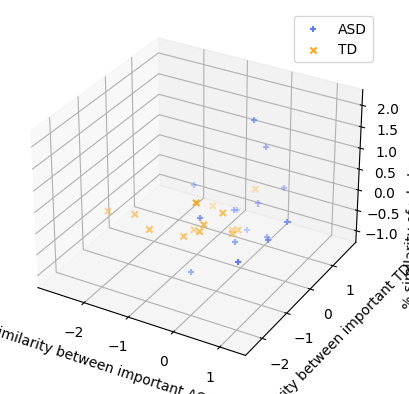

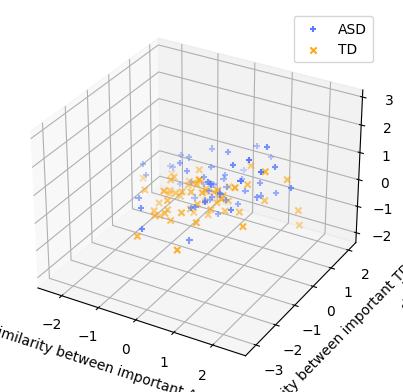

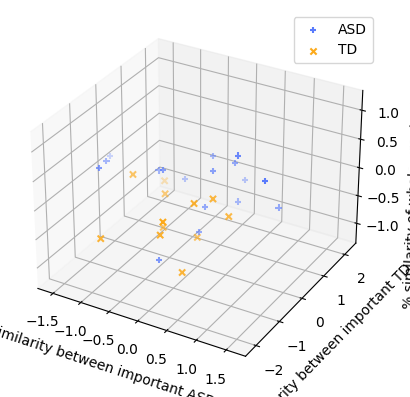

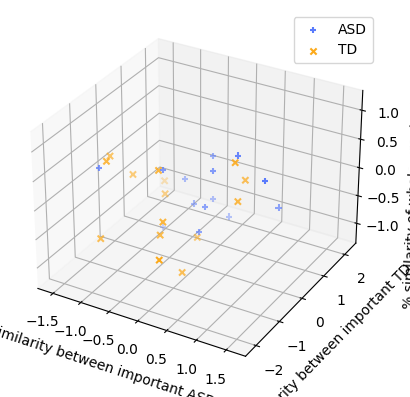

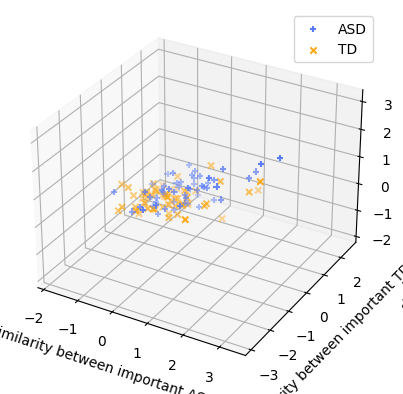

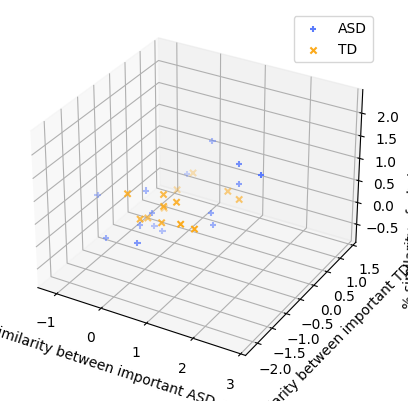

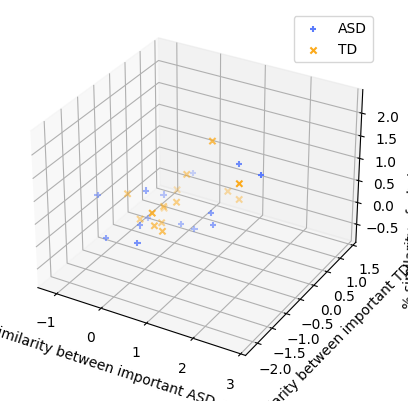

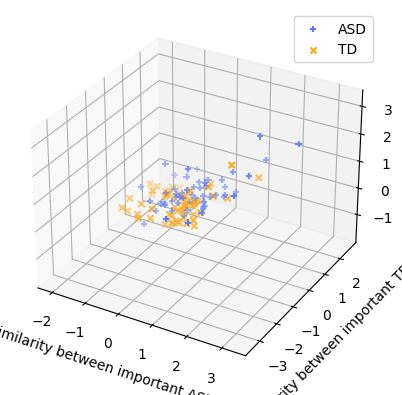

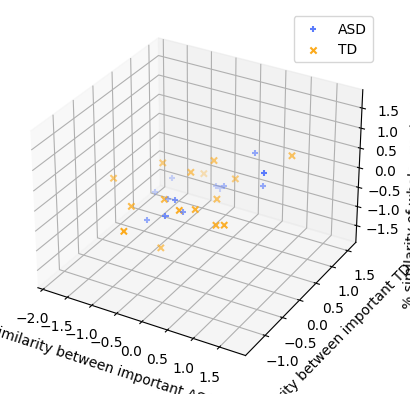

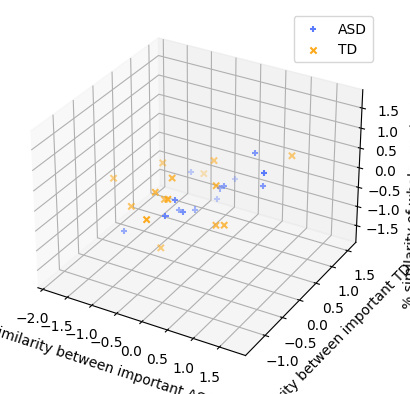

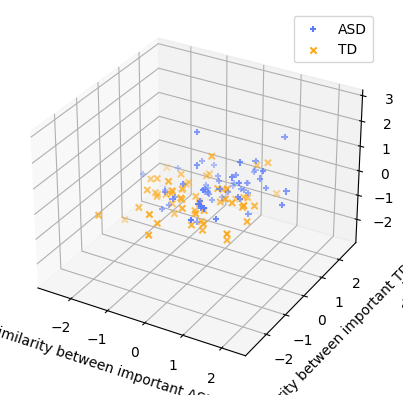

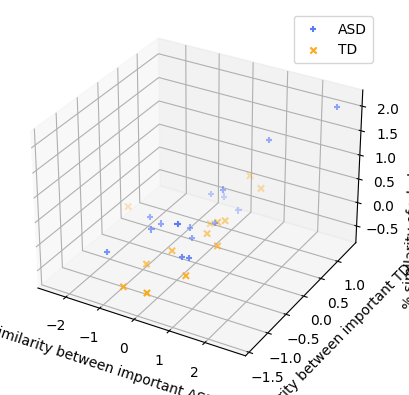

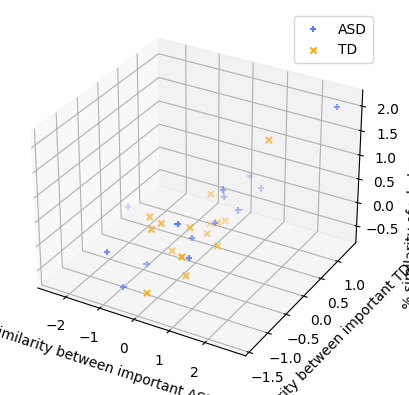

In [19]:
a_label="ASD"
b_label="TD"

# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [0.01, 0.1, 0.5, 1, 10, 50, 100], "gamma": [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1]},
          "DiscriminativeEdgesTransformer": {
            "a_label": [a_label],
            "b_label": [b_label],
            "num_edges": [2, 3, 4, 5, 6, 7, 8, 9],
            }
          }

pipe = [DiscriminativeEdgesTransformer, StandardScaler, SVC]


inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = nested_cv.classify(X=graphs, y=labels, pipeline_steps=pipe, step_params=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, random_state=42, plot_prefix="DE-Child-nested-raw", axes_labels=[f"% similarity between important {a_label} edges",
                            f"% similarity between important {b_label} edges",
                            f"% similarity of whole graph with {a_label} class"], a_label=a_label, b_label=b_label)
results

In [4]:
import nested_cv
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [0.5, 1, 10], "gamma": [0.00005, 0.0001]},
          "ContrastSubgraphTransformer": {
            "a_label": ["ASD"],
            "b_label": ["TD"],
            "alpha": [None],
            "alpha2": [None],
            "percentile": [80],
            "percentile2": [70],
            "solver": [qp],
            "problem": [1],
            "num_cs": [2],
            }
          }

pipe = [ContrastSubgraphTransformer, StandardScaler, SVC]


inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = nested_cv.classify(X=graphs, y=labels, pipeline_steps=pipe, step_params=p_grid, outer_cv=outer_cv, inner_cv=inner_cv)
results

alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.04105571847507333 (70-th percentile)
Time for QP: 0:00:00.079203
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2  6 44 45 48 50 51 66 67]
Objective function value: 1.9804496578690127
Time for local search: 0:00:00.034144
Time to find CS: 0:00:00.113347
Time for QP: 0:00:00.004151
CS before local search: []
Objective function value: 0.0
CS after local search: [  3  10  14  22  23  34  51  64  65  84  85  86  87  93 110]
Objective function value: 4.050830889540566
Time for local search: 0:00:00.028467
Time to find CS: 0:00:00.032618
alpha = 0.06842619745845552 (80-th percentile), alpha2 = 0.03548387096774167 (70-th percentile)
Time for QP: 0:00:00.019811
CS before local search: []
Objective function value: 0.0
CS after local search: [ 8 18 19 27 28 29 34 35 36 38 39 48 61 62 63 65 66 67 76 86]
Objective function value: 6.254154447702835
Time for local search: 0:00:00.058679
Time to find CS: 0:0

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

Time for QP: 0:00:00.006625
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2  6 44 45 48 50 51 66 67]
Objective function value: 1.9804496578690127
Time for local search: 0:00:00.046142
Time to find CS: 0:00:00.052767
Time for QP: 0:00:00.009735
CS before local search: []
Objective function value: 0.0
CS after local search: [  3  10  14  22  23  34  51  64  65  84  85  86  87  93 110]
Objective function value: 4.050830889540566
Time for local search: 0:00:00.023975
Time to find CS: 0:00:00.033710
alpha = 0.06842619745845552 (80-th percentile), alpha2 = 0.03548387096774167 (70-th percentile)
Time for QP: 0:00:00.006512
CS before local search: []
Objective function value: 0.0
CS after local search: [ 8 18 19 27 28 29 34 35 36 38 39 48 61 62 63 65 66 67 76 86]
Objective function value: 6.254154447702835
Time for local search: 0:00:00.058522
Time to find CS: 0:00:00.065034
Time for QP: 0:00:00.007413
CS before local search: []
Objective function value: 0.0

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

CS after local search: [  0   4   5   6   7   8   9  10  11  12  13  14  15  52  53  56  57  58
  60  61  65  82  83  85  89  90  92  93 102]
Objective function value: 11.407624633431098
Time for local search: 0:00:00.077160
Time to find CS: 0:00:00.106417
alpha = 0.06842619745845552 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.010488
CS before local search: []
Objective function value: 0.0
CS after local search: [ 36  37  38  42  46  47  65  66  83  84  85  86  87  97 100 102]
Objective function value: 5.476050830889539
Time for local search: 0:00:00.023200
Time to find CS: 0:00:00.033688
Time for QP: 0:00:00.010416
CS before local search: [12]
Objective function value: 0.0
CS after local search: [ 2  9 10 11 12 14 17 18 19 20 21 22 27 30 44 46 51 58 62 81]
Objective function value: 5.66080156402737
Time for local search: 0:00:00.042988
Time to find CS: 0:00:00.053404


/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004181
CS before local search: []
Objective function value: 0.0
CS after local search: [ 36  37  38  39  40  41  46  54  55  71  74  76  77  95  96  97  98  99
 109 112 114]
Objective function value: 6.525904203323558
Time for local search: 0:00:00.053335
Time to find CS: 0:00:00.057516
Time for QP: 0:00:00.004739
CS before local search: [103]
Objective function value: 0.0
CS after local search: [  0   1   4   5   8   9  11  12  13  15  28  56  57  58  59  60  61  62
  69  83  92  93  99 100 101 102 103 106 111 112]
Objective function value: 9.499511241446724
Time for local search: 0:00:00.037833
Time to find CS: 0:00:00.042572
alpha = 0.06451612903225806 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003274
CS before local search: []
Objective function value: 0.0
CS after local search: [ 0  1 18 19 33 50 57 58 59]
Objective fu

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06744868035190621 (80-th percentile), alpha2 = 0.03421309872922784 (70-th percentile)
Time for QP: 0:00:00.003791
CS before local search: []
Objective function value: 0.0
CS after local search: [ 36  37  38  40  41  54  55  76  87  89  95  96  97  99 112 114]
Objective function value: 3.8914956011730144
Time for local search: 0:00:00.052379
Time to find CS: 0:00:00.056170
Time for QP: 0:00:00.005899
CS before local search: []
Objective function value: 0.0
CS after local search: [  0   4   5   6   7   8   9  11  12  13  14  15  52  53  58  60  61  63
  65  69  83  89  90  92  93 100]
Objective function value: 10.168132942326466
Time for local search: 0:00:00.037600
Time to find CS: 0:00:00.043499
alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.03792766373411506 (70-th percentile)
Time for QP: 0:00:00.005786
CS before local search: []
Objective function value: 0.0
CS after local search: [10 12 31 34 47 66 97 98]
Objective function value: 0.8885630498533723
Time for l

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.0625 (80-th percentile), alpha2 = 0.03125 (70-th percentile)
Time for QP: 0:00:00.004522
CS before local search: []
Objective function value: 0.0
CS after local search: [10 17 20 29 30 31 36 37 38 40 41 55 70 71 74 75 76 77 79 81 95 96 97]
Objective function value: 6.84375
Time for local search: 0:00:00.043676
Time to find CS: 0:00:00.048198
Time for QP: 0:00:00.005869
CS before local search: [ 86 103]
Objective function value: -0.03125
CS after local search: [  0  16  17  19  28  29  46  47  48  53  55  56  68  72  78  79  80  81
  82  83  86  99 100 102 103 104 108]
Objective function value: 9.59375
Time for local search: 0:00:00.059298
Time to find CS: 0:00:00.065167
alpha = 0.0625 (80-th percentile), alpha2 = 0.03125 (70-th percentile)
Time for QP: 0:00:00.003153
CS before local search: []
Objective function value: 0.0
CS after local search: [31 32 33 34 37 38 39 40 48 54 55]
Objective function value: 1.5625
Time for local search: 0:00:00.032369
Time to find CS: 0:00:00.0

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003968
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 11 16 28 36 37 60 61 79 95]
Objective function value: 1.064516129032258
Time for local search: 0:00:00.041484
Time to find CS: 0:00:00.045452
Time for QP: 0:00:00.005442
CS before local search: [92]
Objective function value: 0.0
CS after local search: [  4   5   8   9  15  18  24  25  26  27  33  34  35  64  66  70  75  82
  84  86  88  89  91  92  93 100 112]
Objective function value: 10.090909090909093
Time for local search: 0:00:00.049898
Time to find CS: 0:00:00.055340
alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003547
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 31 37 38 42 43 44 45 57 59 61 87]
Objective function value: 1.5444770283479956
Time for local search: 0:

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.005719
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 11 16 28 36 37 60 61 79 95]
Objective function value: 1.064516129032258
Time for local search: 0:00:00.041618
Time to find CS: 0:00:00.047337
Time for QP: 0:00:00.013113
CS before local search: [92]
Objective function value: 0.0
CS after local search: [  4   5   8   9  15  18  24  25  26  27  33  34  35  64  66  70  75  82
  84  86  88  89  91  92  93 100 112]
Objective function value: 10.090909090909093
Time for local search: 0:00:00.055080
Time to find CS: 0:00:00.068193
alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004405
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 31 37 38 42 43 44 45 57 59 61 87]
Objective function value: 1.5444770283479956
Time for local search: 0:

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.033491461100568574 (70-th percentile)
Time for QP: 0:00:00.004131
CS before local search: []
Objective function value: 0.0
CS after local search: [16 19 33 56 60 62 63]
Objective function value: 0.9003795066413665
Time for local search: 0:00:00.017089
Time to find CS: 0:00:00.021220
Time for QP: 0:00:00.003838
CS before local search: []
Objective function value: 0.0
CS after local search: [  0   4   5   6   7   9  10  11  13  15  18  28  29  32  33  53  72  76
  77  82  83  90 108]
Objective function value: 5.257210626186133
Time for local search: 0:00:00.043027
Time to find CS: 0:00:00.046865
alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.03320683111954459 (70-th percentile)
Time for QP: 0:00:00.003980
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1  3  7 21 61 75 82 99]
Objective function value: 0.8036053130929792
Time for local search: 0:00:00.025395
Time to find CS: 0:00:00.02

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.03823529411764638 (70-th percentile)
Time for QP: 0:00:00.003781
CS before local search: []
Objective function value: 0.0
CS after local search: [ 10  16  20  21  36  37  38  63  70  72  73  74  75  76  80 112]
Objective function value: 4.395635673624287
Time for local search: 0:00:00.023666
Time to find CS: 0:00:00.027447
Time for QP: 0:00:00.013129
CS before local search: []
Objective function value: 0.0
CS after local search: [  4   5   6   7   8   9  13  15  35  58  60  64  66  67  70  71  88  89
  92  93 102]
Objective function value: 5.523719165085531
Time for local search: 0:00:00.058164
Time to find CS: 0:00:00.071293
alpha = 0.06451612903225806 (80-th percentile), alpha2 = 0.04174573055028463 (70-th percentile)
Time for QP: 0:00:00.003626
CS before local search: []
Objective function value: 0.0
CS after local search: [ 7 19 34 67 68 70 74 80 91]
Objective function value: 1.0332068311195446
Time for local search: 0:00:0

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.034155597722960174 (70-th percentile)
Time for QP: 0:00:00.004026
CS before local search: []
Objective function value: 0.0
CS after local search: [  3   4   7  13  19  22  23 106]
Objective function value: 1.1925996204933593
Time for local search: 0:00:00.023595
Time to find CS: 0:00:00.027621
Time for QP: 0:00:00.003828
CS before local search: []
Objective function value: 0.0
CS after local search: [  0   1   5  14  48  51  52  58  59  60  61  89  90  91  92  95  99 100
 101 102 103 104 106 108 113]
Objective function value: 7.458254269449711
Time for local search: 0:00:00.060115
Time to find CS: 0:00:00.063943
alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.03320683111954459 (70-th percentile)
Time for QP: 0:00:00.004607
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 14 25 50 51 61 62 81]
Objective function value: 1.1204933586337762
Time for local search: 0:00:00.017012
Time to 

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06439393939393939 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003803
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 11 17 30 31 37 39 70 71 73 75 77 79 81]
Objective function value: 3.1231060606060606
Time for local search: 0:00:00.052111
Time to find CS: 0:00:00.055914
Time for QP: 0:00:00.005634
CS before local search: [5]
Objective function value: 0.0
CS after local search: [  4   5   8   9  13  15  24  25  26  27  33  35  64  65  75  77  82  86
  88  89  91  92  93 100 102 110]
Objective function value: 10.576704545454545
Time for local search: 0:00:00.043350
Time to find CS: 0:00:00.048984
alpha = 0.06534090909090909 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004178
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2  5 11 12 19 20]
Objective function value: 0.8759469696969698
Time for local search: 0:00:00.0187

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.05677655677655677 (80-th percentile), alpha2 = 0.034798534798534786 (70-th percentile)
Time for QP: 0:00:00.003825
CS before local search: []
Objective function value: 0.0
CS after local search: [  3   4   5   7  19  23 106]
Objective function value: 0.7948717948717952
Time for local search: 0:00:00.017948
Time to find CS: 0:00:00.021773
Time for QP: 0:00:00.011182
CS before local search: []
Objective function value: 0.0
CS after local search: [  0   4   5   6   7   8   9  12  13  15  35  52  58  60  61  65  66  88
  89  92  93 100 102]
Objective function value: 5.899267399267401
Time for local search: 0:00:00.073514
Time to find CS: 0:00:00.084696
alpha = 0.05677655677655677 (80-th percentile), alpha2 = 0.038278388278387594 (70-th percentile)
Time for QP: 0:00:00.008841
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 13 14 51 52 62 82]
Objective function value: 1.113553113553114
Time for local search: 0:00:00.046684
Time to find CS: 0:00:0

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

CS after local search: [ 16  45  46  47  48  49  51  52  53  55  56  57  68  78  80  81  83  90
  98 102 103 104 106 108 111]
Objective function value: 7.34701857282502
Time for local search: 0:00:00.071191
Time to find CS: 0:00:00.076817
alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.03304007820136827 (70-th percentile)
Time for QP: 0:00:00.043302
CS before local search: []
Objective function value: 0.0
CS after local search: [14 37 40 50 51 55 57 96]
Objective function value: 1.2404692082111437
Time for local search: 0:00:00.049024
Time to find CS: 0:00:00.092326
Time for QP: 0:00:00.004712
CS before local search: [24]
Objective function value: 0.0
CS after local search: [ 3 14 17 21 22 23 24 26 27 29 30 33 41 59 62 64 66 67 69 75 85 86]
Objective function value: 5.924926686217069
Time for local search: 0:00:00.028212
Time to find CS: 0:00:00.032924


/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.03714565004887588 (70-th percentile)
Time for QP: 0:00:00.021393
CS before local search: []
Objective function value: 0.0
CS after local search: [  3   5   7   9  19  23  26  27  59 115]
Objective function value: 2.088954056695992
Time for local search: 0:00:00.038280
Time to find CS: 0:00:00.059673
Time for QP: 0:00:00.004744
CS before local search: []
Objective function value: 0.0
CS after local search: [ 16  45  46  47  48  49  51  52  53  55  56  57  68  78  80  81  83  90
  98 102 103 104 106 108 111]
Objective function value: 7.34701857282502
Time for local search: 0:00:00.069429
Time to find CS: 0:00:00.074173
alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.03304007820136827 (70-th percentile)
Time for QP: 0:00:00.006793
CS before local search: []
Objective function value: 0.0
CS after local search: [14 37 40 50 51 55 57 96]
Objective function value: 1.2404692082111437
Time for local search: 0:00:00.043787
Tim

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

CS after local search: [10 16 20 21 28 29 36 37 38 40 41 54 62 63 70 71 72 73 74 75 76 77 79 80
 81 85]
Objective function value: 12.106261859582546
Time for local search: 0:00:00.043408
Time to find CS: 0:00:00.047540
Time for QP: 0:00:00.007282
CS before local search: []
Objective function value: 0.0
CS after local search: [  4   5   6   8   9  12  13  15  25  64  70  71  88  90  92  93 110]
Objective function value: 3.767552182163185
Time for local search: 0:00:00.054355
Time to find CS: 0:00:00.061637
alpha = 0.06451612903225806 (80-th percentile), alpha2 = 0.047438330170778004 (70-th percentile)
Time for QP: 0:00:00.003214
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2  3  5  7  9 19 22 23 47 49 79 89]
Objective function value: 1.7115749525616701
Time for local search: 0:00:00.027726
Time to find CS: 0:00:00.030940
Time for QP: 0:00:00.003564
CS before local search: []
Objective function value: 0.0
CS after local search: [10 29 30 58 73 74 78 8

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.04554079696394686 (70-th percentile)
Time for QP: 0:00:00.005242
CS before local search: []
Objective function value: 0.0
CS after local search: [10 16 20 21 29 30 31 32 36 37 38 40 41 62 63 70 71 72 73 74 75 76 77 80
 81 82 83]
Objective function value: 9.841555977229604
Time for local search: 0:00:00.024915
Time to find CS: 0:00:00.030157
Time for QP: 0:00:00.005299
CS before local search: []
Objective function value: 0.0
CS after local search: [  4   5   8   9  13  15  20  26  60  70  71  88  89  90  91  92  93  95
  99 103 109 110]
Objective function value: 5.4127134724857715
Time for local search: 0:00:00.044387
Time to find CS: 0:00:00.049686
alpha = 0.06451612903225806 (80-th percentile), alpha2 = 0.04174573055028463 (70-th percentile)
Time for QP: 0:00:00.004590
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1  3 10 15 28 53 56 62]
Objective function value: 1.4307400379506643
Time for 

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

CS after local search: [  4  26  43  51  59 104]
Objective function value: 0.8197343453510437
Time for local search: 0:00:00.037938
Time to find CS: 0:00:00.041791
Time for QP: 0:00:00.016913
CS before local search: []
Objective function value: 0.0
CS after local search: [ 39  52  57  59  61  62  63  66  69  89  90  91  98  99 100 101 102 103
 104 106 111 113]
Objective function value: 7.237191650853891
Time for local search: 0:00:00.065067
Time to find CS: 0:00:00.081980
alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.03510436432637576 (70-th percentile)
Time for QP: 0:00:00.010511
CS before local search: []
Objective function value: 0.0
CS after local search: [  9  11  15  19  26  34  35  36  38  39  50  53  65  67  68  69  71  74
  75  76 106]
Objective function value: 5.673624288425049
Time for local search: 0:00:00.033867
Time to find CS: 0:00:00.044378
Time for QP: 0:00:00.004723
CS before local search: [25]
Objective function value: 0.0
CS after local search: [ 2  4  

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06534090909090909 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004011
CS before local search: []
Objective function value: 0.0
CS after local search: [10 16 36 37 38 40 41 54 62 70 71 72 73 74 75 76 77 79 80 81 84 85 87]
Objective function value: 7.6155303030303045
Time for local search: 0:00:00.038405
Time to find CS: 0:00:00.042416
Time for QP: 0:00:00.005332
CS before local search: []
Objective function value: 0.0
CS after local search: [ 16  17  24  25  28  29  32  33  42  43  45  46  47  53  56  68  72  78
  79  80  81 105 108 109 111]
Objective function value: 6.703598484848486
Time for local search: 0:00:00.052832
Time to find CS: 0:00:00.058164
alpha = 0.06439393939393939 (80-th percentile), alpha2 = 0.03598484848484851 (70-th percentile)
Time for QP: 0:00:00.003740
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1  3 10 15 34 54 59 65 66 79 89]
Objective function value: 1.1704545454545454


/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.057142857142858494 (80-th percentile), alpha2 = 0.04029304029304029 (70-th percentile)
Time for QP: 0:00:00.003933
CS before local search: []
Objective function value: 0.0
CS after local search: [10 16 20 29 36 37 40 41 54 57 62 63 70 71 72 73 74 75 76 77 79 80 81 85]
Objective function value: 7.939194139193766
Time for local search: 0:00:00.026552
Time to find CS: 0:00:00.030485
Time for QP: 0:00:00.004019
CS before local search: []
Objective function value: 0.0
CS after local search: [  4   5   8   9  13  15  20  25  35  64  66  70  71  77  88  90  91  92
  93 110]
Objective function value: 4.728937728937728
Time for local search: 0:00:00.063836
Time to find CS: 0:00:00.067855
alpha = 0.05677655677655677 (80-th percentile), alpha2 = 0.04029304029304029 (70-th percentile)
Time for QP: 0:00:00.004236
CS before local search: []
Objective function value: 0.0
CS after local search: [ 3  5  7  9 20 23 24 49 91]
Objective function value: 1.6794871794871797
Time for local search: 0

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003903
CS before local search: []
Objective function value: 0.0
CS after local search: [ 3  4  5  7 19 22 23 50]
Objective function value: 0.9814271749755614
Time for local search: 0:00:00.018585
Time to find CS: 0:00:00.022488
Time for QP: 0:00:00.006119
CS before local search: [92]
Objective function value: 0.0
CS after local search: [  2   4   5   6   7   8   9  11  12  13  14  15  19  25  58  60  61  64
  65  70  71  75  77  88  90  91  92  93  99 100 101 102 103 104 111 112]
Objective function value: 13.94916911045944
Time for local search: 0:00:00.049022
Time to find CS: 0:00:00.055141
alpha = 0.06744868035190621 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004368
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2 43 59 61 74]
Objective function value: 0.5464320625610943
Time for local s

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06647116324535679 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003831
CS before local search: []
Objective function value: 0.0
CS after local search: [ 3  4  5  7 19 22 23 50]
Objective function value: 0.9814271749755614
Time for local search: 0:00:00.018224
Time to find CS: 0:00:00.022055
Time for QP: 0:00:00.013081
CS before local search: [92]
Objective function value: 0.0
CS after local search: [  2   4   5   6   7   8   9  11  12  13  14  15  19  25  58  60  61  64
  65  70  71  75  77  88  90  91  92  93  99 100 101 102 103 104 111 112]
Objective function value: 13.94916911045944
Time for local search: 0:00:00.045423
Time to find CS: 0:00:00.058504
alpha = 0.06744868035190621 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004020
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2 43 59 61 74]
Objective function value: 0.5464320625610943
Time for local s

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.03889943074003796 (70-th percentile)
Time for QP: 0:00:00.003852
CS before local search: []
Objective function value: 0.0
CS after local search: [10 11 17 20 36 37 38 40 55 70 71 72 74 75 76 77 79 80 81 95]
Objective function value: 6.806451612903224
Time for local search: 0:00:00.042505
Time to find CS: 0:00:00.046357
Time for QP: 0:00:00.003932
CS before local search: []
Objective function value: 0.0
CS after local search: [  1   4   5   8   9  12  15  25  60  61  66  70  71  77  89  90  92  93
  95  98  99 100 101 102 103 104 110 111]
Objective function value: 8.562618595825427
Time for local search: 0:00:00.080437
Time to find CS: 0:00:00.084369
alpha = 0.06451612903225806 (80-th percentile), alpha2 = 0.030360531309297945 (70-th percentile)
Time for QP: 0:00:00.003553
CS before local search: []
Objective function value: 0.0
CS after local search: [ 3  6  7  8 18 19 40 58 68 70]
Objective function value: 1.571157495256167
Ti

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.03889943074003796 (70-th percentile)
Time for QP: 0:00:00.003952
CS before local search: []
Objective function value: 0.0
CS after local search: [10 16 17 20 36 37 40 41 56 57 62 63 72 73 74 75 76 77 79 80 81 95]
Objective function value: 11.347248576850099
Time for local search: 0:00:00.027465
Time to find CS: 0:00:00.031417
Time for QP: 0:00:00.003901
CS before local search: []
Objective function value: 0.0
CS after local search: [  4   5   8   9  13  15  60  64  70  71  75  77  88  89  90  91  92  93
  95  99 103 104 105 109 110 111]
Objective function value: 8.588235294117643
Time for local search: 0:00:00.047253
Time to find CS: 0:00:00.051154
alpha = 0.06451612903225806 (80-th percentile), alpha2 = 0.03320683111954459 (70-th percentile)
Time for QP: 0:00:00.003262
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2  3  4  6  7  8 18 19 22 42 55]
Objective function value: 2.0341555977229597


/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06736242884250473 (80-th percentile), alpha2 = 0.03320683111954459 (70-th percentile)
Time for QP: 0:00:00.003689
CS before local search: []
Objective function value: 0.0
CS after local search: [17 36 37 39 40 41 57 62 63 73 74 75 76 77 79 81 83 85]
Objective function value: 5.149905123339661
Time for local search: 0:00:00.068921
Time to find CS: 0:00:00.072610
Time for QP: 0:00:00.009660
CS before local search: [92]
Objective function value: 0.0
CS after local search: [  4   5   8   9  15  58  59  60  61  70  71  77  88  89  90  91  92  93
  95  99 100 101 102 103 104 106 109 110 111]
Objective function value: 11.752371916508544
Time for local search: 0:00:00.052926
Time to find CS: 0:00:00.062586
alpha = 0.06451612903225806 (80-th percentile), alpha2 = 0.030360531309297945 (70-th percentile)
Time for QP: 0:00:00.004783
CS before local search: []
Objective function value: 0.0
CS after local search: [ 1 35 48 69 70 71 95]
Objective function value: 1.0066413662239089
Time for 

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

CS after local search: [ 12  16  17  28  29  32  45  46  48  51  52  53  55  63  65  72  78  80
  81  89  90  99 108 113]
Objective function value: 5.2064393939393945
Time for local search: 0:00:00.071394
Time to find CS: 0:00:00.078566
alpha = 0.0634469696969697 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003731
CS before local search: []
Objective function value: 0.0
CS after local search: [29 39 60 62 78 80 82]
Objective function value: 0.5160984848484849
Time for local search: 0:00:00.014023
Time to find CS: 0:00:00.017754
Time for QP: 0:00:00.006790
CS before local search: []
Objective function value: 0.0
CS after local search: [ 2  4  5  6  7  8  9 14 17 18 22 27 28 45 46 47 48 55 56 61 69 71 72 78
 79 87]
Objective function value: 7.58333333333333
Time for local search: 0:00:00.038663
Time to find CS: 0:00:00.045453


/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.05677655677655677 (80-th percentile), alpha2 = 0.03663003663003661 (70-th percentile)
Time for QP: 0:00:00.004265
CS before local search: []
Objective function value: 0.0
CS after local search: [10 17 20 36 37 38 39 40 41 55 57 62 63 70 71 72 74 75 76 77 79 81 83 95]
Objective function value: 6.0860805860805876
Time for local search: 0:00:00.033001
Time to find CS: 0:00:00.037266
Time for QP: 0:00:00.009745
CS before local search: []
Objective function value: 0.0
CS after local search: [  2   4   5   8   9  20  22  24  25  27  30  33  34  35  64  70  71  77
  82  88  91  92  93 110]
Objective function value: 6.115384615384622
Time for local search: 0:00:00.040192
Time to find CS: 0:00:00.049937
alpha = 0.054945054945054944 (80-th percentile), alpha2 = 0.034798534798534786 (70-th percentile)
Time for QP: 0:00:00.004153
CS before local search: []
Objective function value: 0.0
CS after local search: [ 0  1 15 45 62 64 65 66]
Objective function value: 0.9597069597069594
Time for 

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.0625 (80-th percentile), alpha2 = 0.03125 (70-th percentile)
Time for QP: 0:00:00.003827
CS before local search: []
Objective function value: 0.0
CS after local search: [17 30 36 37 38 39 41 54 55 71 73 74 75 76 77 79 81 83 85 94 95]
Objective function value: 6.03125
Time for local search: 0:00:00.050658
Time to find CS: 0:00:00.054485
Time for QP: 0:00:00.005193
CS before local search: [110]
Objective function value: 0.0
CS after local search: [  0   4   5   6   7   8   9  11  12  13  15  58  60  61  65  71  75  77
  83  88  90  92  99 101 102 108 109 110]
Objective function value: 11.3125
Time for local search: 0:00:00.060352
Time to find CS: 0:00:00.065545
alpha = 0.0625 (80-th percentile), alpha2 = 0.03125 (70-th percentile)
Time for QP: 0:00:00.004626
CS before local search: []
Objective function value: 0.0
CS after local search: [ 4  5  8 35 36 37 38 41 42 43 44 57 58 60]
Objective function value: 3.25
Time for local search: 0:00:00.018517
Time to find CS: 0:00:00.02314

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.0625 (80-th percentile), alpha2 = 0.03125 (70-th percentile)
Time for QP: 0:00:00.003831
CS before local search: []
Objective function value: 0.0
CS after local search: [17 30 36 37 38 39 41 54 55 71 73 74 75 76 77 79 81 83 85 94 95]
Objective function value: 6.03125
Time for local search: 0:00:00.050397
Time to find CS: 0:00:00.054228
Time for QP: 0:00:00.004801
CS before local search: [110]
Objective function value: 0.0
CS after local search: [  0   4   5   6   7   8   9  11  12  13  15  58  60  61  65  71  75  77
  83  88  90  92  99 101 102 108 109 110]
Objective function value: 11.3125
Time for local search: 0:00:00.059500
Time to find CS: 0:00:00.064301
alpha = 0.0625 (80-th percentile), alpha2 = 0.03125 (70-th percentile)
Time for QP: 0:00:00.004638
CS before local search: []
Objective function value: 0.0
CS after local search: [ 4  5  8 35 36 37 38 41 42 43 44 57 58 60]
Objective function value: 3.25
Time for local search: 0:00:00.018797
Time to find CS: 0:00:00.02343

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06534090909090909 (80-th percentile), alpha2 = 0.03125 (70-th percentile)
Time for QP: 0:00:00.004148
CS before local search: []
Objective function value: 0.0
CS after local search: [ 15  17  20  21  29  30  36  37  38  39  40  41  54  70  71  72  73  74
  75  76  77  79  81  95 106]
Objective function value: 8.695075757575758
Time for local search: 0:00:00.043888
Time to find CS: 0:00:00.048036
Time for QP: 0:00:00.010106
CS before local search: [  5 110]
Objective function value: 0.14962121212121213
CS after local search: [  4   5   6   7   8   9  11  13  14  15  26  35  52  58  60  61  64  65
  71  83  88  89  90  91  92  93 100 101]
Objective function value: 13.57102272727273
Local Search improved solution by 8970.253164556963%
Time for local search: 0:00:00.043712
Time to find CS: 0:00:00.053818
alpha = 0.0634469696969697 (80-th percentile), alpha2 = 0.03882575757575757 (70-th percentile)
Time for QP: 0:00:00.003524
CS before local search: []
Objective function value: 0.

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06534090909090909 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.003811
CS before local search: []
Objective function value: 0.0
CS after local search: [  2   6   7   8  19  23  48  49  51  59  66  67  69 105]
Objective function value: 3.285037878787879
Time for local search: 0:00:00.037765
Time to find CS: 0:00:00.041576
Time for QP: 0:00:00.007298
CS before local search: [ 5 25]
Objective function value: -0.022727272727272735
CS after local search: [  4   5   6   7   8   9  11  13  15  21  25  33  34  35  53  60  64  65
  70  71  82  83  88  90  91  92  94 100 109]
Objective function value: 9.949810606060607
Time for local search: 0:00:00.043966
Time to find CS: 0:00:00.051264
alpha = 0.06628787878787878 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.005672
CS before local search: []
Objective function value: 0.0
CS after local search: [13 15 22 23 24 25 30 31 32 33 34 35 45 46 57 58 59 60

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.06439393939393939 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004208
CS before local search: []
Objective function value: 0.0
CS after local search: [ 4  6 12 22 23 28 70]
Objective function value: 1.3560606060606057
Time for local search: 0:00:00.024696
Time to find CS: 0:00:00.028904
Time for QP: 0:00:00.005300
CS before local search: [ 0 18]
Objective function value: -0.17613636363636367
CS after local search: [  2   4   5   6   7   8   9  11  13  14  15  35  58  60  61  65  71  83
  88  89  90  91  92  93 100 101 111]
Objective function value: 13.142045454545457
Time for local search: 0:00:00.054037
Time to find CS: 0:00:00.059337
alpha = 0.06534090909090909 (80-th percentile), alpha2 = 0.043087121212121215 (70-th percentile)
Time for QP: 0:00:00.004126
CS before local search: []
Objective function value: 0.0
CS after local search: [12 14 23 30 31 32 33 35 49 64 66 67 68 70 72 74 78 82 88]
Objective function value: 4.615530303

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

CS after local search: [  3   5  15  18  22  23  24  25  27  34  35  58  64  65  66  75  77  82
  88  91  92  93 100 110]
Objective function value: 6.432765151515154
Time for local search: 0:00:00.052447
Time to find CS: 0:00:00.059323
alpha = 0.0634469696969697 (80-th percentile), alpha2 = 0.030303030303030304 (70-th percentile)
Time for QP: 0:00:00.004465
CS before local search: []
Objective function value: 0.0
CS after local search: [ 8 18 31 33 34 35 38 39 40 41 54 55 80]
Objective function value: 2.127840909090909
Time for local search: 0:00:00.029358
Time to find CS: 0:00:00.033823
Time for QP: 0:00:00.003995
CS before local search: [0]
Objective function value: 0.0
CS after local search: [ 0  1 10 13 14 15 19 23 42 45 46 47 50 51 57 61 62 63 64 77 78 79 80 81
 85]
Objective function value: 8.394886363636362
Time for local search: 0:00:00.023428
Time to find CS: 0:00:00.027423


/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

alpha = 0.0554878048780488 (80-th percentile), alpha2 = 0.040243902439024426 (70-th percentile)
Time for QP: 0:00:00.042918
CS before local search: []
Objective function value: 0.0
CS after local search: [17 20 29 30 31 36 37 38 39 40 41 54 55 70 71 72 73 74 75 76 77 79 81 83
 85 87 89 95]
Objective function value: 10.01768292682926
Time for local search: 0:00:00.044707
Time to find CS: 0:00:00.087625
Time for QP: 0:00:00.005904
CS before local search: []
Objective function value: 0.0
CS after local search: [  3  22  23  24  25  27  30  31  33  34  35  42  64  77  82  84  87  93
 110]
Objective function value: 4.685975609756092
Time for local search: 0:00:00.039143
Time to find CS: 0:00:00.045047
alpha = 0.05304878048780487 (80-th percentile), alpha2 = 0.04390243902439023 (70-th percentile)
Time for QP: 0:00:00.009423
CS before local search: []
Objective function value: 0.0
CS after local search: [29 30 31 32 33 34 37 38 39 40 46 52 53 54 77 86]
Objective function value: 4.242682926829

/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/Keanelek Enns/Documents/Keanu/UVic/MSc/Spring2022/591/brain-network-classification/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: P

[{'results': {'report': {'ASD': {'precision': 0.0,
     'recall': 0.0,
     'f1-score': 0.0,
     'support': 10},
    'TD': {'precision': 0.5238095238095238,
     'recall': 1.0,
     'f1-score': 0.6875000000000001,
     'support': 11},
    'accuracy': 0.5238095238095238,
    'macro avg': {'precision': 0.2619047619047619,
     'recall': 0.5,
     'f1-score': 0.34375000000000006,
     'support': 21},
    'weighted avg': {'precision': 0.2743764172335601,
     'recall': 0.5238095238095238,
     'f1-score': 0.36011904761904767,
     'support': 21}},
   'confusion_matrix': array([[ 0, 10],
          [ 0, 11]])},
  'params': {'ContrastSubgraphTransformer': {'a_label': 'ASD',
    'alpha': None,
    'alpha2': None,
    'b_label': 'TD',
    'num_cs': 2,
    'percentile': 80,
    'percentile2': 70,
    'problem': 1,
    'solver': <function dense_subgraph.qp(diff_net, alpha)>},
   'SVC': {'C': 0.5, 'gamma': 0.0001}},
  'trained_pipeline': [ContrastSubgraphTransformer(a_label='ASD', alpha=0.0575359

In [7]:
import math


x = np.array([ np.array([_, math.sin(_)]) for _ in range(23)])
print(x)
stdsclr = StandardScaler()
print(stdsclr.fit_transform(x))
y = np.array([ np.array([_, 2*_]) for _ in range(6)])
stdsclr.transform(y)

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  8.41470985e-01]
 [ 2.00000000e+00  9.09297427e-01]
 [ 3.00000000e+00  1.41120008e-01]
 [ 4.00000000e+00 -7.56802495e-01]
 [ 5.00000000e+00 -9.58924275e-01]
 [ 6.00000000e+00 -2.79415498e-01]
 [ 7.00000000e+00  6.56986599e-01]
 [ 8.00000000e+00  9.89358247e-01]
 [ 9.00000000e+00  4.12118485e-01]
 [ 1.00000000e+01 -5.44021111e-01]
 [ 1.10000000e+01 -9.99990207e-01]
 [ 1.20000000e+01 -5.36572918e-01]
 [ 1.30000000e+01  4.20167037e-01]
 [ 1.40000000e+01  9.90607356e-01]
 [ 1.50000000e+01  6.50287840e-01]
 [ 1.60000000e+01 -2.87903317e-01]
 [ 1.70000000e+01 -9.61397492e-01]
 [ 1.80000000e+01 -7.50987247e-01]
 [ 1.90000000e+01  1.49877210e-01]
 [ 2.00000000e+01  9.12945251e-01]
 [ 2.10000000e+01  8.36655639e-01]
 [ 2.20000000e+01 -8.85130929e-03]]
[[-1.6583124  -0.11558027]
 [-1.50755672  1.10944112]
 [-1.35680105  1.20818349]
 [-1.20604538  0.08986357]
 [-1.05528971 -1.21734047]
 [-0.90453403 -1.51159126]
 [-0.75377836 -0.52235598]
 [-0.

array([[-1.6583124 , -0.11558027],
       [-1.50755672,  2.79603857],
       [-1.35680105,  5.70765741],
       [-1.20604538,  8.61927625],
       [-1.05528971, 11.53089508],
       [-0.90453403, 14.44251392]])

In [ ]:
# # Set up possible values of parameters to optimize over
# p_grid = {"svc__C": [0.1, 1],
#           "svc__gamma": [0.00001, 0.0001],
#           "contrastsubgraphtransformer__a_label": ["ASD"],
#           "contrastsubgraphtransformer__b_label": ["TD"],
#           "contrastsubgraphtransformer__alpha": [None, 0.01],
#           "contrastsubgraphtransformer__alpha2": [None, 0.02],
#           "contrastsubgraphtransformer__percentile": [77],
#           "contrastsubgraphtransformer__percentile2": [79],
#           "contrastsubgraphtransformer__solver": [sdp],
#           "contrastsubgraphtransformer__problem": [1],
#           "contrastsubgraphtransformer__num_cs": [1],
#           }

# pipe = make_pipeline(ContrastSubgraphTransformer(), StandardScaler(), SVC())


# inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# # Nested CV with parameter optimization
# clf = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=inner_cv)
# # nested_score = cross_validate(clf, X=graphs, y=labels, cv=outer_cv, return_estimator=True)
# X_train, X_test, y_train, y_test = train_test_split(graphs, labels, train_size=0.8, shuffle=True, random_state=42)
# clf.fit(X_train, y_train)
# print(classification_report(y_true=y_test, y_pred=clf.predict(X_test)))

In [ ]:
# Set up possible values of parameters to optimize over
# p_grid = [{"svc__C": [0.1, 1],
#           "svc__gamma": [0.00001, 0.0001],
#           "discriminativeedgestransformer__num_edges": [5, 6, 7]},
#           ]

# pipe = make_pipeline(DiscriminativeEdgesTransformer(a_label="ASD", b_label="TD", num_edges=6), StandardScaler(), SVC())


# inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# # Nested CV with parameter optimization
# clf = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=inner_cv)
# nested_score = cross_validate(clf, X=graphs, y=labels, cv=outer_cv)
# nested_score, clf.get_params(deep=True)